## Mini-Project 3:  HOUSE PRICE PREDICTION USING TEXT AND IMAGES 

### CSC 215-01 Artificial Intelligence (Fall 2019)

### Team member : 
    1) Subham Tewari

### Problem Formulation :   
    The goal of this project is to build a novel automatic house price estimation system by using both textual and visual inputs, other than only using textual information such as area, neighborhood, and number of bedrooms.
            
### Models used to predict House Price : 
- Combination of Fully-Connected deep Neural Networks and CNN.




## import libraries

In [ ]:
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets,linear_model, preprocessing,utils
from sklearn.metrics import mean_squared_error,r2_score
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pyplot import figure, show
from keras.layers import Conv1D, Conv2D, MaxPooling2D 
import keras
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten ,Dropout
import cv2
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
import glob
from keras.layers import concatenate
from keras.models import Model
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from IPython.display import Image
from google.colab import drive 
drive.mount('/content/gdrive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)
    

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

## Load dataset

In [ ]:
filename_read = os.path.join("/content/gdrive/My Drive/Colab Notebooks/Houses Dataset/HousesInfo.txt")

In [ ]:
cols=["Bedrooms","Bathrooms","area","zipcode","price"]

In [ ]:
df = pd.read_csv(filename_read , sep=" ", header=None , names=cols)

In [ ]:
df[:5]

,Bedrooms,Bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [ ]:
df.shape

(535, 5)

#### Kept the houses with a price between 50K and 900K
#### Store index of outliers in a list, So that we can remove it from visual images using that index.

In [ ]:
outlier= df.index[df['price'] <= 50000].tolist()
outlier1= df.index[df['price'] >= 900000].tolist()
outlier= outlier+outlier1

In [ ]:
len(outlier)

83

#### Remove Outliers.

In [ ]:
df = df.loc[(df['price'] > 50000) & (df['price'] < 900000)]

In [ ]:
df[:5]

,Bedrooms,Bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
6,3,4.0,2544,85262,799000
10,5,5.0,4829,85266,519200


In [ ]:
df.shape

(452, 5)

#### For all missing values, inserted MEAN values using defination "missing_median".

In [ ]:
missing_median(df,'Bedrooms')
missing_median(df,'Bathrooms')
missing_median(df,'area')
missing_median(df,'price')

#### Encode categorical features using defination "encode_text_dummy".

In [ ]:
encode_text_dummy(df, 'Bedrooms')
encode_text_dummy(df, 'Bathrooms')
encode_text_dummy(df,'zipcode')

In [ ]:
df.shape

(452, 63)

#### Normalize numeric features using "Z-Score".

In [ ]:
encode_numeric_zscore(df, 'area')

In [ ]:
df[:5]

,area,price,Bedrooms-1,Bedrooms-2,Bedrooms-3,Bedrooms-4,Bedrooms-5,Bedrooms-6,Bedrooms-7,Bedrooms-8,Bedrooms-10,Bathrooms-1.0,Bathrooms-1.5,Bathrooms-2.0,Bathrooms-2.5,Bathrooms-3.0,Bathrooms-3.25,Bathrooms-3.5,Bathrooms-4.0,Bathrooms-4.5,Bathrooms-5.0,Bathrooms-6.0,zipcode-36372,zipcode-60002,zipcode-60016,zipcode-60046,zipcode-62025,zipcode-62034,zipcode-62088,zipcode-62214,zipcode-62234,zipcode-62249,zipcode-81418,zipcode-81521,zipcode-81524,zipcode-85255,zipcode-85262,zipcode-85266,zipcode-85331,zipcode-91752,zipcode-91901,zipcode-91915,zipcode-92021,zipcode-92253,zipcode-92276,zipcode-92543,zipcode-92677,zipcode-92692,zipcode-92802,zipcode-92880,zipcode-93105,zipcode-93111,zipcode-93314,zipcode-93446,zipcode-93510,zipcode-93720,zipcode-94501,zipcode-94531,zipcode-94565,zipcode-94568,zipcode-95220,zipcode-96019,zipcode-98021
0,1.652649,869500,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.022859,865200,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.537335,889000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0.314122,799000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,2.340984,519200,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Handling Images dataset

In [ ]:
## Bathroom.jpg
new_images=[]
for number in range(1, 536):
    for path in glob.glob("/content/gdrive/My Drive/Colab Notebooks/Houses Dataset/" + str(number) + "_bathroom.jpg"):
        if os.path.isfile(path):
            new_images.append(path) 

In [ ]:
new_images[:5]

['/content/gdrive/My Drive/Colab Notebooks/Houses Dataset/1_bathroom.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Houses Dataset/2_bathroom.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Houses Dataset/3_bathroom.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Houses Dataset/4_bathroom.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Houses Dataset/5_bathroom.jpg']

In [ ]:
img= pd.DataFrame(new_images,columns = ['bathroom_img'])

In [ ]:
## bedroom images
bedroom_images = []
for number in range(1, 536):
    for path in glob.glob("/content/gdrive/My Drive/Colab Notebooks/Houses Dataset/" + str(number) + "_bedroom.jpg"):
        if os.path.isfile(path):
            bedroom_images.append(path) 

In [ ]:
img['bedroom_img']=bedroom_images

In [ ]:
frontal_images = []
for number in range(1, 536):
    for path in glob.glob("/content/gdrive/My Drive/Colab Notebooks/Houses Dataset/" + str(number) + "_frontal.jpg"):
        if os.path.isfile(path):
            frontal_images.append(path) 

In [ ]:
img['frontal_img']=frontal_images

In [ ]:
kitchen_images = []
for number in range(1, 536):
    for path in glob.glob("/content/gdrive/My Drive/Colab Notebooks/Houses Dataset/" + str(number) + "_kitchen.jpg"):
        if os.path.isfile(path):
            kitchen_images.append(path) 

In [ ]:
img['kitchen_img']=kitchen_images

In [ ]:
img.head()

,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,/content/gdrive/My Drive/Colab Notebooks/House...,/content/gdrive/My Drive/Colab Notebooks/House...,/content/gdrive/My Drive/Colab Notebooks/House...,/content/gdrive/My Drive/Colab Notebooks/House...
1,/content/gdrive/My Drive/Colab Notebooks/House...,/content/gdrive/My Drive/Colab Notebooks/House...,/content/gdrive/My Drive/Colab Notebooks/House...,/content/gdrive/My Drive/Colab Notebooks/House...
2,/content/gdrive/My Drive/Colab Notebooks/House...,/content/gdrive/My Drive/Colab Notebooks/House...,/content/gdrive/My Drive/Colab Notebooks/House...,/content/gdrive/My Drive/Colab Notebooks/House...
3,/content/gdrive/My Drive/Colab Notebooks/House...,/content/gdrive/My Drive/Colab Notebooks/House...,/content/gdrive/My Drive/Colab Notebooks/House...,/content/gdrive/My Drive/Colab Notebooks/House...
4,/content/gdrive/My Drive/Colab Notebooks/House...,/content/gdrive/My Drive/Colab Notebooks/House...,/content/gdrive/My Drive/Colab Notebooks/House...,/content/gdrive/My Drive/Colab Notebooks/House...


In [ ]:
img.shape

(535, 4)

In [ ]:
img = img.drop(outlier)

In [ ]:
img.shape

(452, 4)

## Concatenate houses images into one image for each house

In [ ]:
images_output=[]
for row_index,row in img.iterrows():
            inputImages=[]
            outputImage = np.zeros((128, 128, 3), dtype="uint8")
            image_temp1 = cv2.imread(row.bathroom_img)
            image1 = cv2.resize(image_temp1, (64 , 64))
            
            image_temp2 = cv2.imread(row.bedroom_img)
            image2 = cv2.resize(image_temp2, (64 , 64))
            
            image_temp3 = cv2.imread(row.frontal_img)
            image3 = cv2.resize(image_temp3, (64 , 64))
            
            image_temp4 = cv2.imread(row.kitchen_img)
            image4 = cv2.resize(image_temp4, (64 , 64))
              
            inputImages.append(image1)
            inputImages.append(image2)
            inputImages.append(image3)
            inputImages.append(image4)
            
            outputImage[0:64, 0:64] = inputImages[0]
            outputImage[0:64, 64:128] = inputImages[1]
            outputImage[64:128, 64:128] = inputImages[2]
            outputImage[64:128, 0:64] = inputImages[3]
            
        
            images_output.append(outputImage)      
            

In [ ]:
from matplotlib import pyplot as plt

for i in images_output:
     plt.figure(figsize=(8,8))
     plt.imshow(i, interpolation='nearest')
     #plt.show()

## Create numpy arrays of images

In [ ]:
len(images_output)

452

In [ ]:
img_arr=np.asarray(images_output)

In [ ]:
img_arr.shape

(452, 128, 128, 3)

#### Separate textual dataset into x and y.

In [ ]:
X_NN = df.drop(['price'], axis = 1)
y_NN = df.loc[:, ['price']]

#### Split both textual and image data into train and test using Scikit-learn's train_test_split method.

In [ ]:
x_train_NN, x_test_NN, y_train_NN, y_test_NN = train_test_split(X_NN, y_NN, test_size=0.3, random_state=42)
print("Shape of x_train: {}".format(x_train_NN.shape))
print("Shape of x_test: {}".format(x_test_NN.shape))
print("Shape of y_train: {}".format(y_train_NN.shape))
print("Shape of y_test: {}".format(y_test_NN.shape))

Shape of x_train: (316, 62)
Shape of x_test: (136, 62)
Shape of y_train: (316, 1)
Shape of y_test: (136, 1)


In [ ]:
img_train, img_test = train_test_split(img_arr, test_size=0.3, random_state=42)
print("Shape of img_train: {}".format(img_train.shape))
print("Shape of img_test: {}".format(img_test.shape))


Shape of img_train: (316, 128, 128, 3)
Shape of img_test: (136, 128, 128, 3)


### Using Keras-functional API, created DENSE and CNN models to extract features from text and image seperately.





Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_1_input (InputLayer)      (None, 62)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          16128       dense_1_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 125, 125, 32) 1568        input_1[0][0]                    
________________________________________________________________________________________

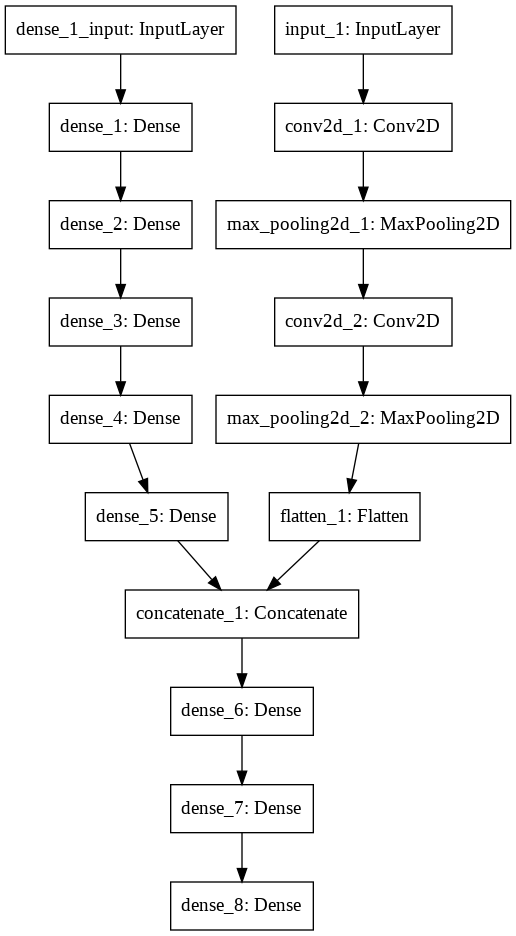

In [ ]:
# Multiple Inputs
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

# first input model
model1 = Sequential()
model1.add(Dense(256, input_dim=x_train_NN.shape[1], activation="relu"))
model1.add(Dense(128, activation="relu"))
model1.add(Dense(64, activation="relu"))
model1.add(Dense(32, activation="relu"))
model1.add(Dense(1, activation="relu"))


# second input model
visible2 = Input(shape=(128,128,3))
conv21 = Conv2D(32, kernel_size=4, activation='relu')(visible2)
pool21 = MaxPooling2D(pool_size=(2, 2))(conv21)
conv22 = Conv2D(16, kernel_size=4, activation='relu')(pool21)
pool22 = MaxPooling2D(pool_size=(2, 2))(conv22)
flat2 = Flatten()(pool22)
model2 = Model(visible2, flat2)

# merge input models
merge = concatenate([model1.output, model2.output])

# interpretation model
hidden1 = Dense(50, activation='relu')(merge)
hidden2 = Dense(40, activation='relu')(hidden1)
output = Dense(1, activation='relu')(hidden2)

model = Model(inputs=[model1.input, model2.input], outputs=output)
# summarize layers
print(model.summary())

# plot model
plot_model(model)



### Trained model using EarlyStopping. Took input of both textual and image data and output as "Price" data.

In [ ]:
checkpointer = ModelCheckpoint(filepath="/content/gdrive/My Drive/best_weights_cnn.hdf5", verbose=0, save_best_only=True) # save best model 

model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
model.fit([x_train_NN, img_train], y_train_NN,batch_size=64,validation_data=([x_test_NN, img_test], y_test_NN),callbacks=[monitor],verbose=2,epochs=1000)






Train on 316 samples, validate on 136 samples
Epoch 1/1000





 - 8s - loss: 248428920417.2152 - val_loss: 266903434420.7059
Epoch 2/1000
 - 7s - loss: 247583229770.5317 - val_loss: 263631531309.1765
Epoch 3/1000
 - 7s - loss: 240469390297.1140 - val_loss: 245386160489.4118
Epoch 4/1000
 - 7s - loss: 208730170484.6582 - val_loss: 183439147008.0000
Epoch 5/1000
 - 7s - loss: 127498824017.0126 - val_loss: 71223451648.0000
Epoch 6/1000
 - 7s - loss: 67180919691.3418 - val_loss: 82844525989.6471
Epoch 7/1000
 - 7s - loss: 73703195298.0253 - val_loss: 57181650703.0588
Epoch 8/1000
 - 7s - loss: 58898259708.7595 - val_loss: 70552834048.0000
Epoch 9/1000
 - 7s - loss: 62508690833.8228 - val_loss: 61806739937.8824
Epoch 10/1000
 - 7s - loss: 54683377404.7595 - val_loss: 56250661225.4118
Epoch 11/1000
 - 7s - loss: 56392697363.4430 - val_loss: 56562525605.6471
Epoch 12/1000
 - 7s - loss: 55590469943.0886 - val_loss: 57432587806.1176
Epoch 13/1000
 - 7s - loss: 54686892706.0253 - val_loss: 

#### Predict model and print out RMSE and R2 Score. 

In [ ]:
from sklearn import metrics

model_pred = model.predict([x_test_NN,img_test])

score = np.sqrt(metrics.mean_squared_error(y_test_NN,model_pred)) 

print("Score (RMSE) : {}".format(score))
print("R2 score     :",metrics.r2_score(y_test_NN,model_pred))
print("MSE          :", metrics.mean_squared_error(y_test_NN, model_pred))

Score (RMSE) : 139922.42029878148
R2 score     : 0.6648726642389936
MSE          : 19578283702.268852


In [ ]:
model_pred = np.asarray(model_pred)
y_test_NN = np.asarray(y_test_NN)

#### Regression Chart.

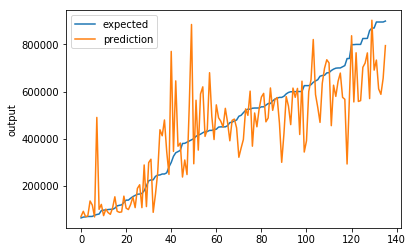

In [ ]:
chart_regression(model_pred.flatten(),y_test_NN)